
### Which not-for-profits might be at the highest risk for fraud?  For not-for-profits, this often happens through contractor payments.

1. Employees/Volunteers/Voting Members as a percentage of over 100K contractors
    - Employees/Volunteers/Voting Members count / count of contractors over 100K
    - fewer employees can translate to weaker controls over vetting and payment of contractors

1. Count of contractors as a percentage of total expenses
    - count of contractors / total expenses
    - this will help identify a larger number of contractors paid a similar amount
    - the larger this number the larger the distribution of expenses accross contractors


*************************
1.  Small number of voting members and independent voting members compared to revenue
    - this could be indicative of low oversight of the organization
    - dataset also includes independent vs. non-independent voting members, unsure about specific differences
1. Salaries expense as a percentage of revenue
    - not-for-profit management could be paying themselves a disproportionate salary
    
1.  Small number of staff members compared to the volume of money raised
    - employee count / current year revenue
    - fewer employees can translate to weaker internal financial controls.


younger organizations vs older organizations


### Data source:
https://www.open990.org/catalog/, this company provides raw data for free, however they also provide analytics services for a charge https://appliednonprofitresearch.com/customdata/

overview of data provided by open990
https://medium.com/@open990/the-irs-990-e-file-dataset-getting-to-the-chocolatey-center-of-data-deliciousness-90f66097a600

This dataset has great documentation about what the attributes mean, however this only includes data for 1 year(2016).

### Not-for-profit info to inform my process
https://en.wikipedia.org/wiki/501(c)_organization - there are many different types of 501(c) orgs, each type is organized around a specific category of activity, labor, social and recreational, business leagues, ect.

__501(c)(3) categories of activity__ - Religious, Educational, Charitable, Scientific, Literary, Testing for Public Safety, to Foster National or International Amateur Sports Competition, or Prevention of Cruelty to Children or Animals Organizations

https://nonprofitrisk.org/resources/articles/a-violation-of-trust-fraud-risk-in-nonprofit-organizations/

One area in which nonprofit organizations seem particularly vulnerable is billing schemes, in which an employee fraudulently submits invoices to obtain payments he or she is not entitled to receive. According to the most recent ACFE survey, billing schemes were among the most common fraud methods in the cases studied for the 2012 report.

Billing schemes often involve the creation of a shell company. In such a fraud, a dishonest employee sets up a fake identity that bills for good or services the organization does not receive. In some instances, goods or services may be delivered but are marked up excessively, with the proceeds diverted to the employee.


In [444]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil

In [4]:
df = pd.read_csv('data/Open990_Contractor_Compensation_Snack_Set_Public_2019-01-24.csv',
                 encoding = 'unicode_escape',
                 engine='python')

### Pre-Processing Steps
1. limit data to only orgs with contractor payments in excess of 100K
1. refine categories of non-profit mission/purpose statements
    - completing this task in *990_mission_statement* notebook.

1. convert NaN values into False
    - for many boolean fields in the 990, the absense of a response is interpreted as NaN, converting these to False will allow for a machine readable format. 
1. format target variable for machine learning algorithems to make predictions on
    - somewhere around 10% of the dataset
    
*************************
#### Additional Considerations
1. refine categories of services being provided to the orgs
    - there is probably a high level of inconsistency here
    - this will require a summarization process similar to what I'm doing for the mission statement of the orgs
    - is there a relationship between the size and type of org and the types of services paid for?


In [38]:
# how large is the full dataset?
df.shape

(237448, 110)

In [39]:
# examine columns in full dataset
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string
0,10018927,AMERICAN LEGION POST 5 BOURQUE-LANIGAN,2016-01-01,2016-12-31,2016,AMERICAN LEGION POST 5,+1 (207) 872-8824,WTVLLEGION.ORG,21 COLLEGE AVENUE,WATERVILLE,ME,NaN,04901,True,NaN,NaN,NaN,NaN,1926.0,925.0,ME,no,NaN,NaN,True,19.0,501808,NaN,9,9,8,0.0,0,0.0,11458.0,0.0,983.0,137239.0,149680.0,0.0,20120.0,61034.0,0.0,0,113034.0,194188.0,-44508.0,595704.0,29618.0,566086.0,12549,0,1036,128465,142050,0,22141,62171,0,100057,184369,-42319,561928,38161,523767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,010018927_201612,2016v3.0,201721359349307007,NzM0MjczMTQ5MzAyOTkxNjA2NQ
1,10018930,AMERICAN LEGION - MAINE DEPARTMENT,2015-05-01,2016-04-30,2016,NaN,+1 (207) 873-3229,WWW.MAINELEGION.ORG,PO BOX 900,WINSLOW,ME,NaN,049010727,True,NaN,NaN,NaN,NaN,1919.0,NaN,ME,no,NaN,NaN,True,19.0,784286,NaN,60,56,10,NaN,0,NaN,488958.0,214498.0,2452.0,62279.0,768187.0,3500.0,NaN,263411.0,NaN,0,518288.0,785199.0,-17012.0,941168.0,364115.0,577053.0,487889,210898,1613,83886,784286,4500,0,245792,0,482665,732957,51329,995802,367420,628382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,010018930_201604,2015v2.1,201622149349301207,NjA2ODIzMDg0NzYyMzA2MDM2NA
2,10019705,Ancient Free and Accepted Masons of Maine Gran...,2015-04-01,2016-03-31,2016,NaN,+1 (207) 358-3110,www.mainemason.org,P O Box 430,Holden,ME,NaN,044290430,True,NaN,NaN,NaN,NaN,1820.0,275.0,ME,no,NaN,NaN,True,10.0,362909,NaN,11,9,5,0.0,0,0.0,1837.0,321565.0,29073.0,1972.0,354447.0,0.0,0.0,78522.0,0.0,0,236707.0,315229.0,39218.0,1704310.0,0.0,1704310.0,1402,315455,29298,-13191,332964,18061,0,86383,0,241884,346328,-13364,1640608,0,1640608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [36]:
# find count of null values
# for each column
(df.isna().sum()/df.isna().count()) * 100

ein                                      0.000000
name_org                                 0.000000
tax_date_begin                           0.000000
tax_date_end                             0.000000
tax_yr                                   0.000000
doing_business_as                       94.005424
phone                                   10.273407
website                                 34.804673
address                                  0.000421
city                                     0.002106
state                                    0.030322
country                                 99.917877
zip                                      0.010529
org_form.corp                           11.653499
org_form.trust                          96.870473
org_form.association                    95.570820
org_form.other_form                     97.630218
org_form.other_form_desc                98.252670
formation_yr                             7.177572
grp_exempt_num                          96.654847


In [5]:
# what is the date range
df.tax_date_begin.min()

'2014-12-27'

In [6]:
df.tax_date_begin.max()

'2016-12-28'

### Limit dataset to only orgs with payments to contractors over 100K

In [42]:
# identify columns
for c in df.columns:
    if '100' in c:
        print(c)       

contractor_100k_ct


In [53]:
# subset data based on orgs with contractor payments over 100K
df_con = df[~df.name_contractor_1.isnull()]

In [54]:
# examine size of data
df_con.shape

(30589, 110)

In [335]:
df_con.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,con_ct_div_emp_ct
13,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,NaN,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,NaN,046190425,True,NaN,NaN,NaN,NaN,1940.0,NaN,ME,no,NaN,False,True,12.0,15549792,NaN,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.050847
17,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,NaN,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,NaN,04104,True,NaN,NaN,NaN,NaN,1931.0,NaN,ME,no,NaN,False,True,14.0,9472036,NaN,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.028302
27,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,NaN,+1 (207) 622-5866,www.maine.nea.org,35 Community D

###  Data Preprocessing

In [255]:
# fill na for financial data
# fill nans with 0 so that I can perform math on these amounts
# when amounts are left blank on the tax return they show up here as NaN

for column in list(df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    df_con[column].fillna(0, inplace=True)

In [169]:
# a number of orgs show non-null values in name_contractor_1
# however either NaN or null in contractor_100k_ct
# this should not be possible 
# in these cases fill in 1 in the contractor_100k_ct

pd.options.mode.chained_assignment = None

df_con.loc[df_con['contractor_100k_ct'].isnull(), 'contractor_100k_ct'] = 1
df_con.loc[df_con['contractor_100k_ct'] == 0, 'contractor_100k_ct'] = 1

In [188]:
# for voting_memb_ct, voting_indepmemb_ct, employee_tot_ct, volunteer_tot_ct
# fill nans with 0 so that I can perform math on these amounts

for column in list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    df_con[column].fillna(0, inplace=True)

In [341]:
# replace nan with False
# for 501c3 column, False values are NaN
# I want to change these to be false
df_con['exempt_status.501c3'].fillna(False, inplace=True)

# this column contains all other 
# subcategories of 501 orgs
# by adding 3, I can have all 501 information in one column
df_con['exempt_status.501c_txt'].fillna(3, inplace=True)


###  General Visualizations

#### Contractor Count

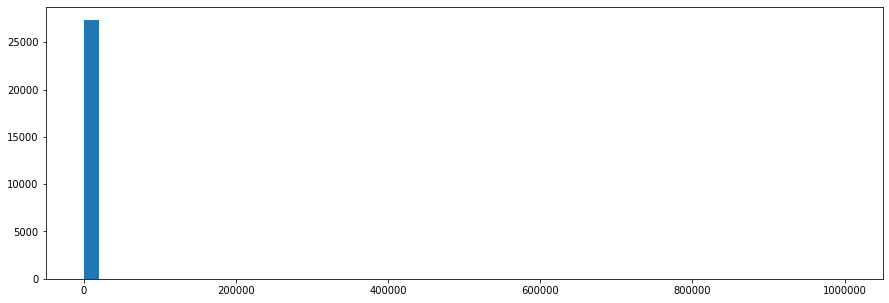

In [439]:
# what is the distribution of the count of contractors?
# there are some huge outliers
fig = plt.figure(figsize=(15, 5))

plt.hist(df_con.contractor_100k_ct, bins=50);

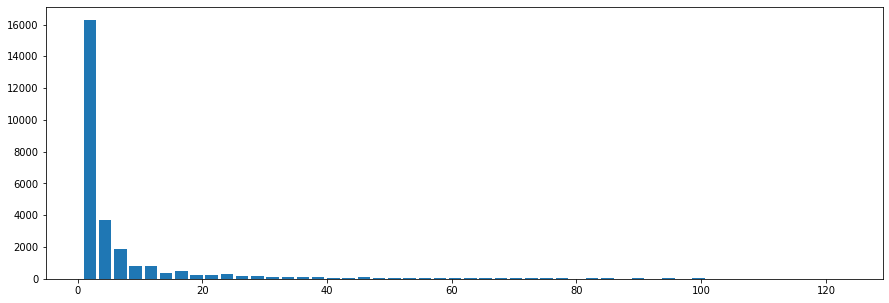

In [469]:
# what is the distribution of the count of contractors?
# there are some huge outliers
# excluding some of the outliers, I can see that this has a very long tail
fig = plt.figure(figsize=(15, 5))

plt.hist(df_con.loc[(np.abs(stats.zscore(df_con.contractor_100k_ct)) < .01),'contractor_100k_ct'], bins=50, width=2);

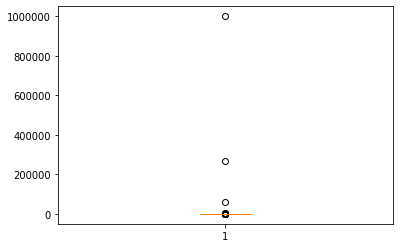

In [441]:
plt.boxplot(df_con.contractor_100k_ct);

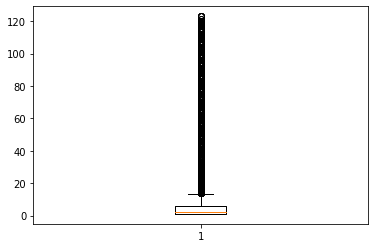

In [470]:
plt.boxplot(df_con.loc[(np.abs(stats.zscore(df_con.contractor_100k_ct)) < .01),'contractor_100k_ct']);

#### Employees/Voting Members/Volunteers

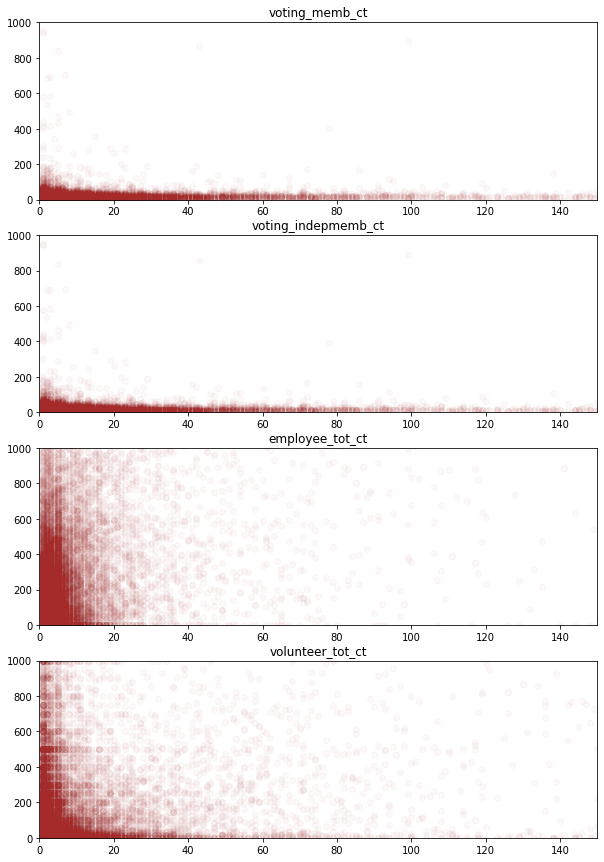

In [416]:
# graph employees against contractor count
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.contractor_100k_ct, df_con[column], color='brown', alpha=.03);
    plt.xlim(0, 150)
    plt.ylim(0, 1000)

it seems that orgs with a high number of contractors don't necessarily have a lot of employees or volunteers

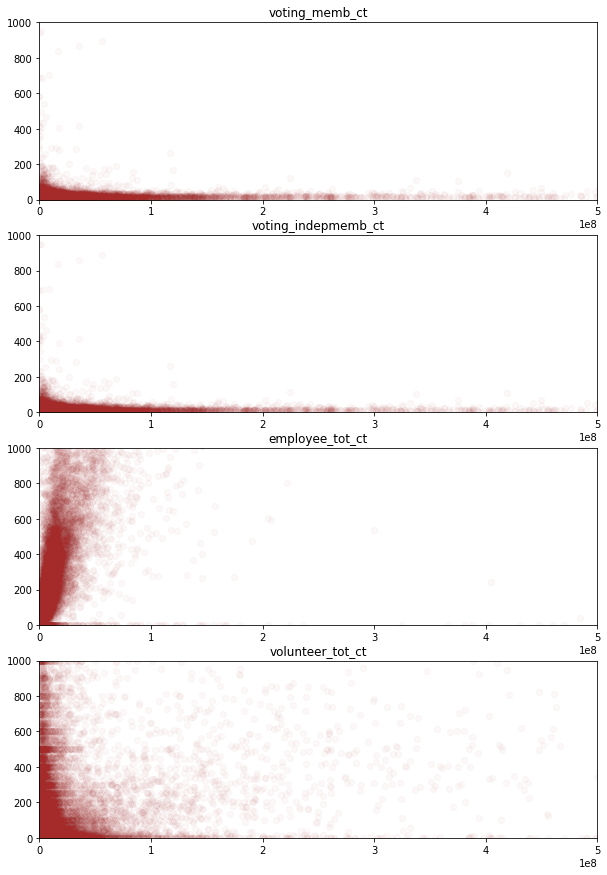

In [279]:
# graph employees against salaries expense
fig = plt.figure(figsize=(10, 15))


for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.salaries_expense_tot_curyr, df_con[column], color='brown', alpha=.03);
    plt.xlim(0, 500000000)
    plt.ylim(0, 1000)


1. there seems to be a positive relationship between employee count and salary expense and 
1. an inverse relationship between salary expense and volunteer count
1. also a slight inverse relationship between voting members and salary expense
1. perhaps voting members and volunteers often perform work of employees in some orgs?

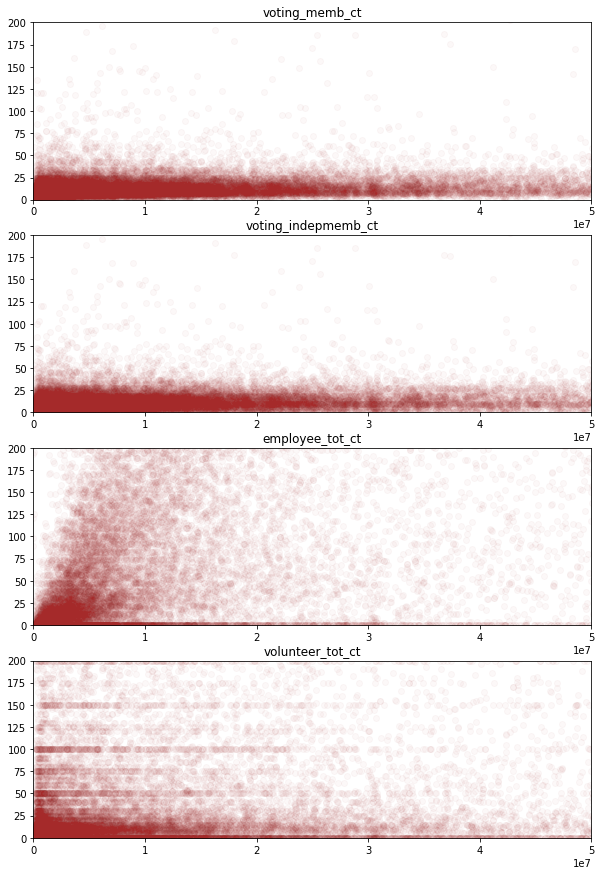

In [288]:
# graph employees against gross receipts
fig = plt.figure(figsize=(10, 15))

for i, column in enumerate(list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns)):
    plt.subplot(4, 1, i+1)
    plt.title(column)
    plt.scatter(df_con.gross_receipts, df_con[column], color='brown', alpha=.03);
    plt.xlim(0, 50000000)
    plt.ylim(0, 200)

Some orgs that receive lots of money have few volunteers

#### Financial Visualizations

In [426]:
df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns

Index(['income_tot_unrelated', 'income_net_unrelated',
       'rev_giftsgrants_tot_prioryr', 'rev_prgmservice_prioryr',
       'rev_investmt_prioryr', 'rev_other_prioryr', 'rev_tot_prioryr',
       'grants_expense_tot_prioryr', 'benefits_expense_tot_prioryr',
       'salaries_expense_tot_prioryr', 'fundraiseservfee_expense_tot_prioryr',
       'fundraise_expense_tot_curyr', 'other_expense_tot_prioryr',
       'expense_tot_prioryr', 'rev_less_expense_prioryr', 'asset_tot_beginyr',
       'liability_tot_beginyr', 'asset_net_beginyr',
       'rev_giftsgrants_tot_curyr', 'rev_prgmservice_curyr',
       'rev_investmt_curyr', 'rev_other_curyr', 'rev_tot_curyr',
       'grants_expense_tot_curyr', 'benefits_expense_tot_curyr',
       'salaries_expense_tot_curyr', 'fundraiseservfee_expense_tot_curyr',
       'other_expense_tot_curyr', 'expense_tot_curyr',
       'rev_less_expense_curyr', 'asset_tot_endyr', 'liability_tot_endyr',
       'asset_net_endyr'],
      dtype='object')

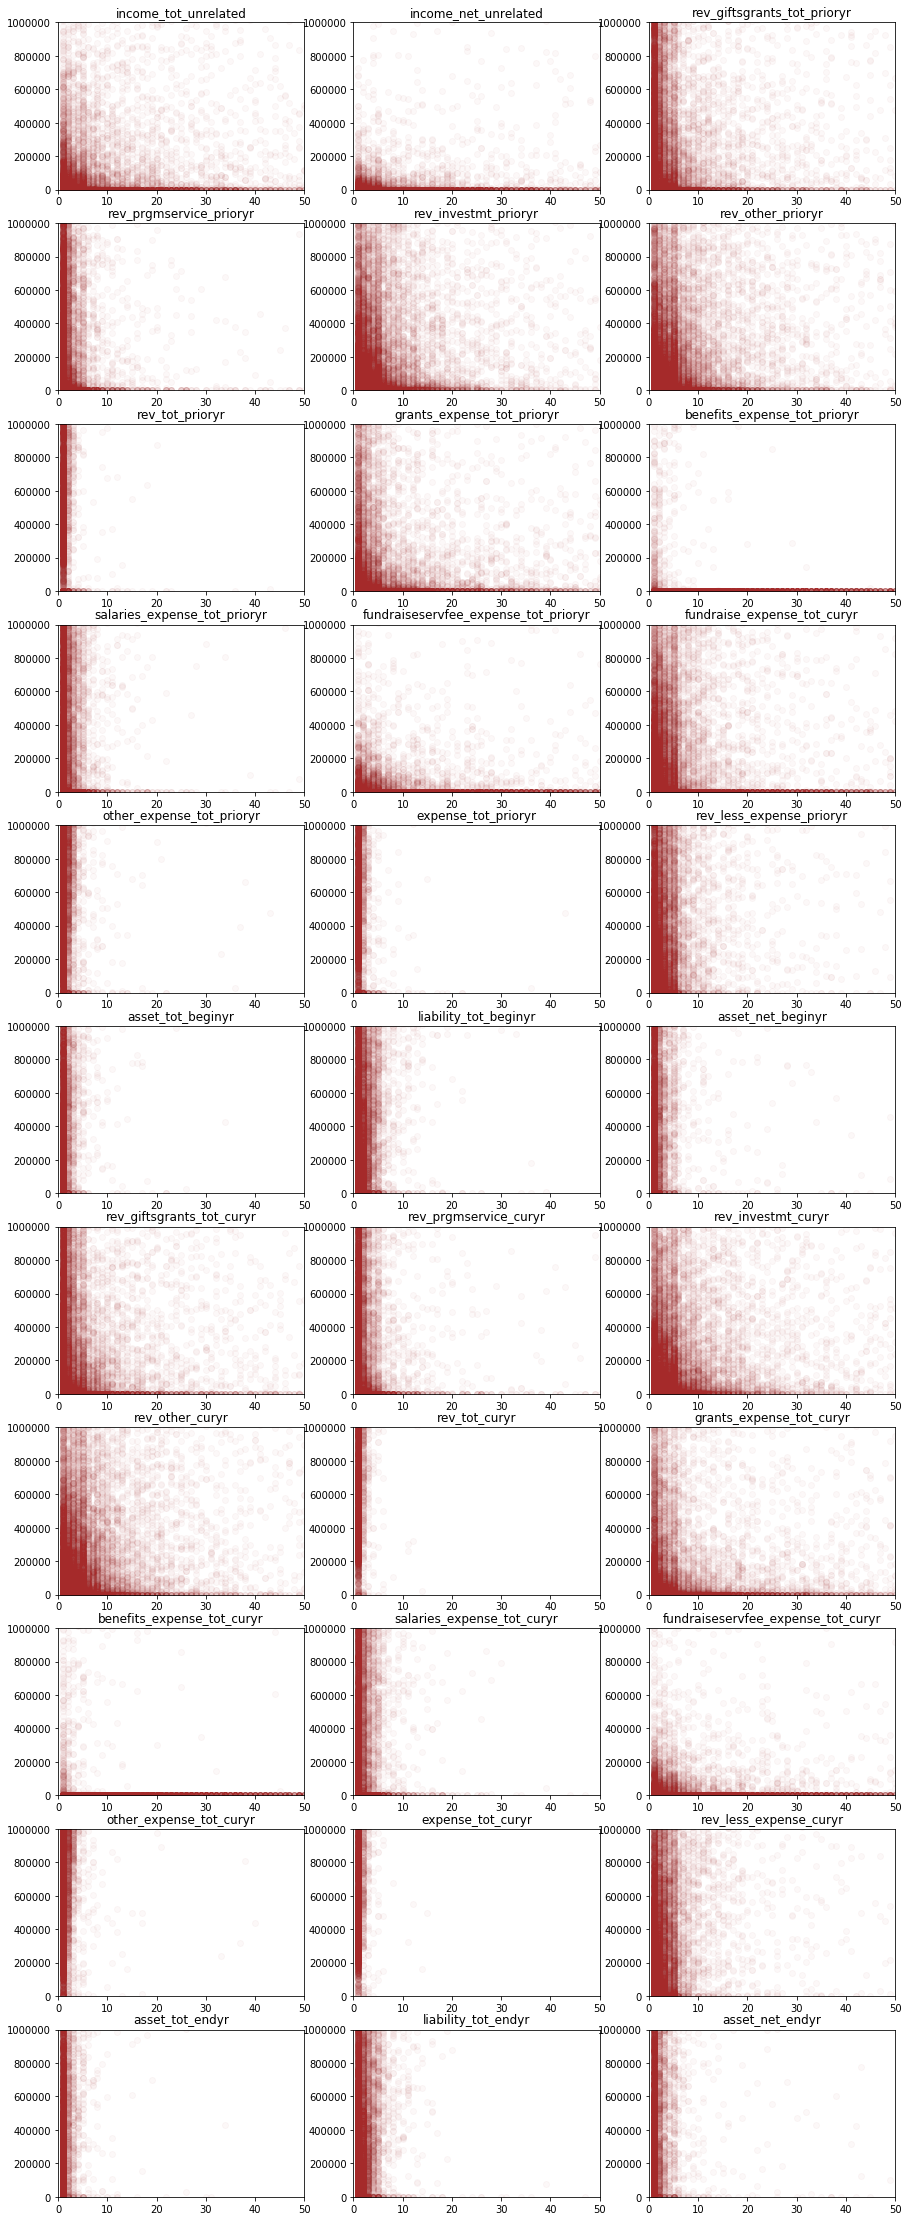

In [474]:
fig = plt.figure(figsize=(15, 40))

for i, column in enumerate(df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns):
    plt.subplot(ceil(len(df_con.loc[:,'income_tot_unrelated' : 'asset_net_endyr'].columns)/3), 3, i+1)
    plt.title(column)
    plt.scatter(df_con.contractor_100k_ct, df_con[column], color='brown', alpha=.03)
    plt.xlim(0, 50)
    plt.ylim(0, 1000000);

#### Correlation Matrix

In [410]:
# examine correlations between features I have created and other features in the dataset
# I'm seeing very little relationship between either of them with any other features

fig = plt.figure(figsize=(10, 15))

df_con.corr().iloc[:,-5:-4].sort_values(by='contractor_100k_ct', ascending=False)

,contractor_100k_ct
contractor_100k_ct,1.000000
con_ct_div_emp_ct,0.839723
con_ct_div_exp,0.295838
voting_indepmemb_ct,0.009806
amt_paid_contractor_4,0.005147
amt_paid_contractor_5,0.004887
rev_tot_prioryr,0.004413
expense_tot_curyr,0.004407
expense_tot_prioryr,0.004355
rev_tot_curyr,0.004312


<Figure size 720x1080 with 0 Axes>

In [415]:
# examine correlations between features I have created and other features in the dataset
# I'm seeing very little relationship between either of them with any other features

fig = plt.figure(figsize=(10, 15))

df_con.corr().iloc[:,-3:].sort_values(by='con_ct_div_emp_ct', ascending=False)

,con_ct_div_emp_ct,con_ct_div_exp,sal_exp_div_tot_exp
con_ct_div_emp_ct,1.000000,0.119547,-0.007279
contractor_100k_ct,0.839723,0.295838,0.000188
con_ct_div_exp,0.119547,1.000000,-0.007723
amt_paid_contractor_5,0.072189,-0.001788,-0.044449
amt_paid_contractor_4,0.068904,-0.001464,-0.041725
other_expense_tot_curyr,0.018950,-0.000595,-0.007969
other_expense_tot_prioryr,0.017635,-0.000595,-0.007030
rev_prgmservice_curyr,0.016599,-0.000831,0.001360
expense_tot_curyr,0.016030,-0.000945,0.000491
rev_prgmservice_prioryr,0.015913,-0.000835,0.001652


<Figure size 720x1080 with 0 Axes>

(54.0, 0.0)

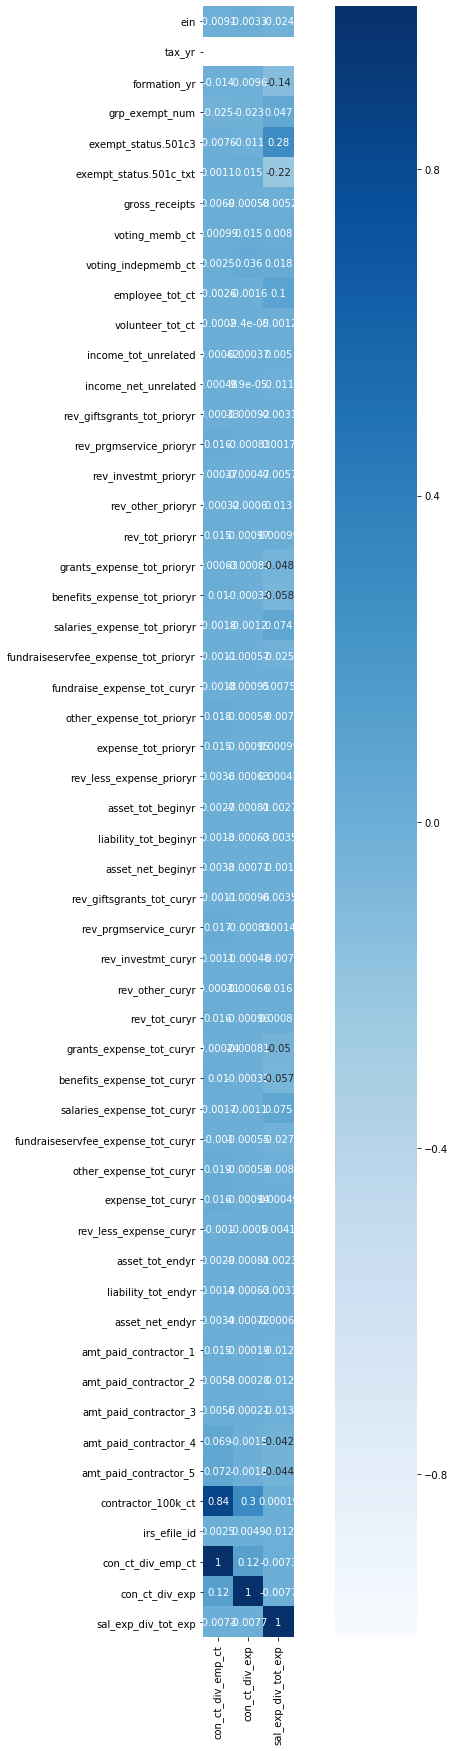

In [479]:
# compare features using a heatmap
plt.figure(figsize=(15, 30))

ax = sns.heatmap(df_con.corr().iloc[:,-3:], 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=True, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(54.0, 0.0)

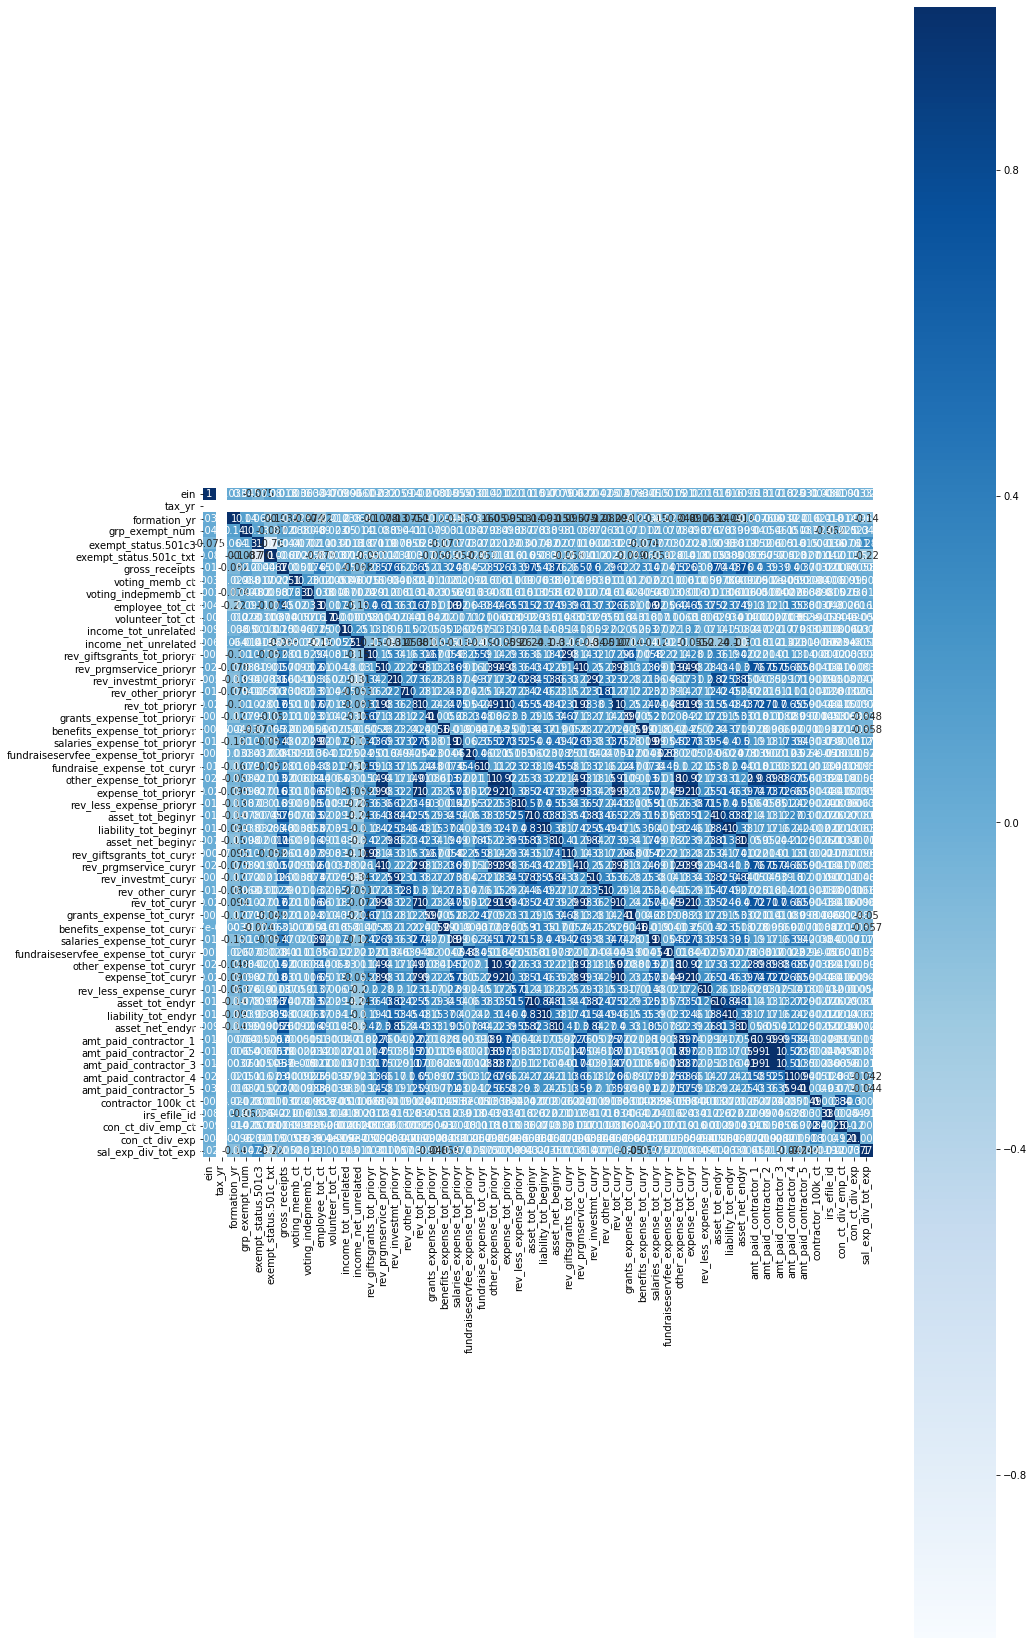

In [480]:
# compare features using a heatmap
plt.figure(figsize=(15, 30))

ax = sns.heatmap(df_con.corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=True, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [382]:
df_con['exempt_status.501c_txt'].value_counts(dropna=False)

3.0     21293
6.0      2346
9.0       985
4.0       728
5.0       492
14.0      491
12.0      436
7.0       356
2.0        64
8.0        56
13.0       45
25.0       25
10.0       12
19.0       12
29.0       10
27.0        3
23.0        2
26.0        2
18.0        2
Name: exempt_status.501c_txt, dtype: int64

###  1. Target variable feature creation - employees, volunteers, and voting members as a percentage of over 100K contractors

In [81]:
# identify columns with employee in them
for c in df.columns:
    if 'vol' in c:
        print(c)       

volunteer_tot_ct


In [150]:
# identify columns with count of vendors
for c in df.columns:
    if '100k_ct' in c:
        print(c)       

contractor_100k_ct


In [196]:
# verify data type
for column in list(df_con.loc[:,'voting_memb_ct' : 'volunteer_tot_ct'].columns):
    print(df_con[column].dtype)

int64
int64
int64
float64


In [201]:
# drop exception orgs
df_con.drop(df_con[df_con['con_ct_div_emp_ct'] == np.inf].index, inplace=True)

In [200]:
# how many orgs had zero employees, independent members, and volunteers?
# this will create 'inf'
# it's not clear to me why orgs will have none of these
# they seem to be outliers, I will drop them for now

df_con[df_con['con_ct_div_emp_ct'] == np.inf].shape

(0, 111)

In [351]:
# SettingWithCopyWarning
# I see no reason why it should be raised in this situation
# pd.options.mode.chained_assignment = None

df_con['con_ct_div_emp_ct'] = df_con['contractor_100k_ct'] / (df_con['employee_tot_ct'] + df.voting_memb_ct + df.voting_indepmemb_ct + df.volunteer_tot_ct)

In [289]:
df_con.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,con_ct_div_emp_ct
13,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,NaN,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,NaN,046190425,True,NaN,NaN,NaN,NaN,1940.0,NaN,ME,no,NaN,NaN,True,12.0,15549792,NaN,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.050847
17,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,NaN,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,NaN,04104,True,NaN,NaN,NaN,NaN,1931.0,NaN,ME,no,NaN,NaN,True,14.0,9472036,NaN,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.028302
27,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,NaN,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive

In [292]:
# why am I still ending up with 3000 + null values?
df_con[df_con['con_ct_div_emp_ct'].isnull()].shape

(0, 111)

In [207]:
# for now I'm just going to drop them
df_con.drop(df_con[df_con['con_ct_div_emp_ct'].isnull()].index, inplace=True)

In [216]:
# how many orgs remain?
df_con['con_ct_div_emp_ct'].shape

(27408,)

#### Identify a percentage of orgs above a threshold to identify as my target variables

In [274]:
# which orgs are three standard deviations from the mean?
# I want to flag the highest numbers since they are 
# indicative of fewer employees handling larger number of contractors
df_con['con_ct_div_emp_ct'].sort_values(ascending=False).head(20)

79651     3058.100917
9578      2095.321429
20554      364.857143
84304      323.227494
197434     219.000000
81350      194.857143
15413      164.428571
21348       61.500000
82385       51.125000
14632       46.600000
105675      37.774194
84923       26.555556
209166      15.000000
30192       14.272727
28873       14.000000
228645      13.000000
194343      12.000000
111020      11.384615
164402      10.611111
16284       10.000000
Name: con_ct_div_emp_ct, dtype: float64

In [226]:
z_scores = zscore(df_con['con_ct_div_emp_ct'])

# iterate through threshold levels
# comparing the value of each z score
# against the value of the threshold

# for threshold == 5:
#     print("The score threshold is: {}".format(threshold))
#     print("The indices of the outliers:")
#     print(np.where(z_scores > threshold))
len((np.where(z_scores > 2)[0]))

10

This doesn't seem right to me.

In [212]:
z_scores[0:10]

array([-0.01152335, -0.0125172 , -0.01331344, -0.01301764, -0.01355783,
       -0.01361137, -0.01361714, -0.0125734 , -0.01210133, -0.01341494])

This seemed to work better for me

In [271]:
# find the 90th quartile
q90 = np.percentile(df_con['con_ct_div_emp_ct'], [90])

q90[0]

0.11226708074534156

In [270]:
# what percent of the total does the 90th quartile make up?
df_con[df_con['con_ct_div_emp_ct'] > q90[0]].shape[0] / df_con.shape[0]

0.1000072971395213

In [273]:
# how many orgs are in my target variable bucket?
df_con[df_con['con_ct_div_emp_ct'] > q90[0]].shape

(2741, 111)

#### Visualizations

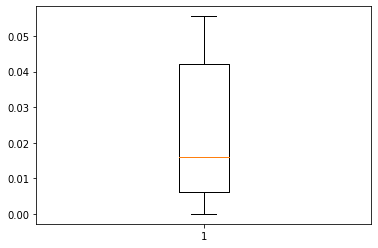

In [353]:
# had to remove outliers just to get it to plot
# otherwise I get an error message
plt.boxplot(winsorize(df_con['con_ct_div_emp_ct'], (0,.2)));

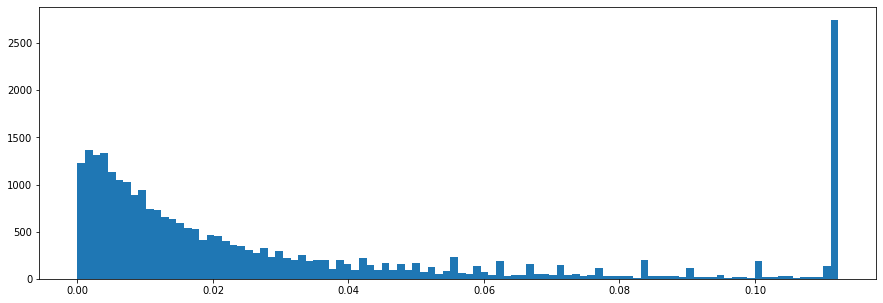

In [296]:
# again I had to winsorize just to avoid error messages
plt.subplots(figsize=(15, 5))

# distribution
plt.hist(winsorize(df_con['con_ct_div_emp_ct'], (0,.1)), bins=100);

(0, 5)

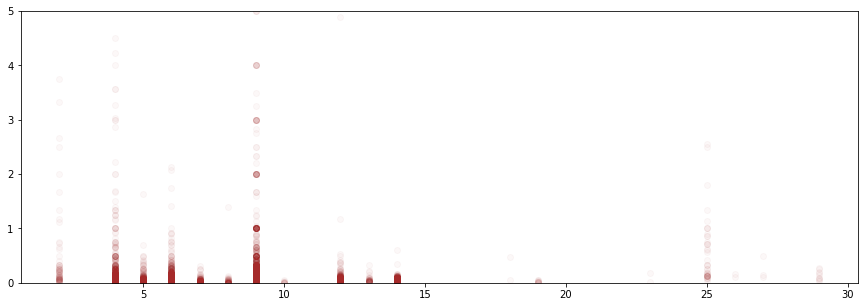

In [317]:
# graph 501c type against feature I created
fig = plt.figure(figsize=(15, 5))

plt.scatter(df_con['exempt_status.501c_txt'], df_con['con_ct_div_emp_ct'], color='brown', alpha=.03);
# plt.xlim(0, 50000000)
plt.ylim(0, 5)

###  2. Target variable feature creation - count of contractors / total expenses
but total expenses is sometimes smaller than 100K, so how did the org pay for the contractor over 100K?
maybe include prior year expense amounts too?

In [357]:
# identify columns
for c in df.columns:
    if 'expense_tot_curyr' in c:
        print(c)       

fundraise_expense_tot_curyr
grants_expense_tot_curyr
benefits_expense_tot_curyr
salaries_expense_tot_curyr
fundraiseservfee_expense_tot_curyr
other_expense_tot_curyr
expense_tot_curyr


In [150]:
# identify columns with count of vendors
for c in df.columns:
    if '100k_ct' in c:
        print(c)       

contractor_100k_ct


In [ ]:
other_expense_tot_curyr

In [358]:
# contractor expense / other expense(expense not spent on salary, fundraising, ect.)
df_con['con_ct_div_exp'] = df_con['contractor_100k_ct'] / df_con['expense_tot_curyr']

In [365]:
# how is it possible for there the be 48 vendors with no expenses
# yet a contractor for which they spent over 100K
df_con[df_con['expense_tot_curyr'] == 0].shape

(48, 112)

In [368]:
# I'm going to drop these for the time being
# this could be a timing issue of some sort

df_con.drop(df_con[df_con['expense_tot_curyr'] == 0].index, inplace=True)

In [369]:
# check to make sure they have been removed
df_con[df_con['expense_tot_curyr'] == 0].shape

(0, 112)

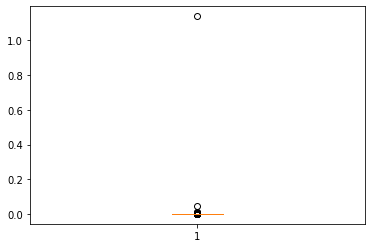

In [372]:
plt.boxplot(df_con['con_ct_div_exp']);

In [362]:
df_con['con_ct_div_exp'].max()

inf

In [363]:
df_con['con_ct_div_exp'].min()

6.015201752609714e-10

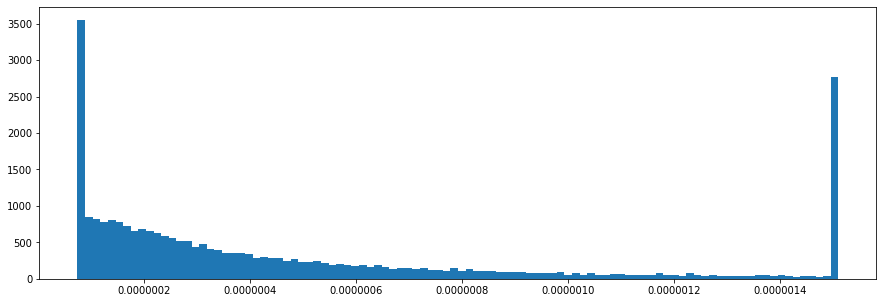

In [377]:
fig = plt.figure(figsize=(15, 5))

plt.hist(winsorize(df_con['con_ct_div_exp'], (.1, .1)), bins=100);

###  3. Target variable feature creation - salaries expense / total expenses


In [357]:
# identify columns
for c in df.columns:
    if 'expense_tot_curyr' in c:
        print(c)       

fundraise_expense_tot_curyr
grants_expense_tot_curyr
benefits_expense_tot_curyr
salaries_expense_tot_curyr
fundraiseservfee_expense_tot_curyr
other_expense_tot_curyr
expense_tot_curyr


In [391]:
df_con['sal_exp_div_tot_exp'] = df_con.salaries_expense_tot_curyr / df_con.expense_tot_curyr

In [392]:
df_con['sal_exp_div_tot_exp'].max()

28.236567166478697

In [393]:
df_con['sal_exp_div_tot_exp'].min()

-0.07239335366946846

{'whiskers': [<matplotlib.lines.Line2D at 0x11194cadc18>,
 'caps': [<matplotlib.lines.Line2D at 0x11194934cc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11194cadeb8>],
 'medians': [<matplotlib.lines.Line2D at 0x11194934898>],
 'fliers': [<matplotlib.lines.Line2D at 0x111954b6f60>],
 'means': []}

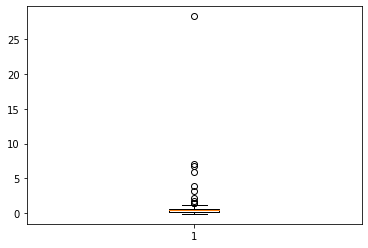

In [396]:
plt.boxplot(df_con['sal_exp_div_tot_exp'])

(array([2.7354e+04, 2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.07239335,  2.7585027 ,  5.58939875,  8.4202948 , 11.25119085,
        14.08208691, 16.91298296, 19.74387901, 22.57477506, 25.40567111,
        28.23656717]),
 <a list of 10 Patch objects>)

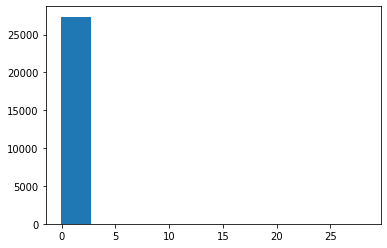

In [397]:
plt.hist(df_con['sal_exp_div_tot_exp'])

### Salaries Exp / Rev

In [123]:
# identify columns with salary in them
for c in df.columns:
    if 'salar' in c:
        print(c)       

salaries_expense_tot_prioryr
salaries_expense_tot_curyr


In [126]:
# identify columns with revenue in them
for c in df.columns:
    if 'rev_tot' in c:
        print(c)       

rev_tot_prioryr
rev_tot_curyr


In [127]:
df['sal_exp_dif_rev'] = df.salaries_expense_tot_curyr / df.rev_tot_curyr

In [132]:
x = df['sal_exp_dif_rev'].copy()

In [135]:
# remove infinite values
x.replace(-np.inf, np.nan, inplace=True)
x.replace(np.inf, np.nan, inplace=True)
x.dropna(inplace=True)

In [144]:
x.max()

107663.5

In [145]:
x.min()

-2925.2

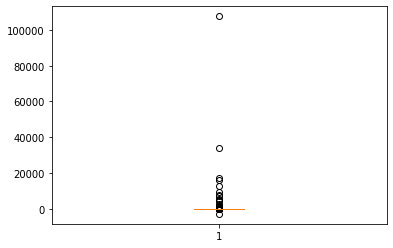

In [146]:
# there are big outliers
plt.boxplot(x);

###  Voting members as a percentage of revenue

In [326]:
# identify columns with vote in them
for c in df.columns:
    if 'vot' in c:
        print(c)       

voting_memb_ct
voting_indepmemb_ct


In [327]:
# identify columns with revenue
for c in df.columns:
    if 'rev_tot' in c:
        print(c)       

rev_tot_prioryr
rev_tot_curyr


In [298]:
df_vote = df.copy()

In [299]:
df_vote['vot_mem_div_rev'] = df_vote.voting_memb_ct / df_vote.rev_tot_curyr

In [300]:
# remove 0 values

df_vote.drop(df_vote[df_vote.voting_memb_ct == 0].index, inplace=True)

In [301]:
# remove inf values

df_vote.drop(df_vote[df_vote['vot_mem_div_rev'] == np.inf].index, inplace=True)

In [302]:
df_vote.voting_memb_ct.value_counts().head()

5    20514
7    20089
9    18792
6    15562
8    14447
Name: voting_memb_ct, dtype: int64

In [303]:
df_vote['vot_mem_div_rev'].value_counts(dropna=False).shape

(228224,)

In [304]:
df_vote['vot_mem_div_rev'].min()

-0.7019543973941368

In [305]:
df_vote['vot_mem_div_rev'].max()

17.5

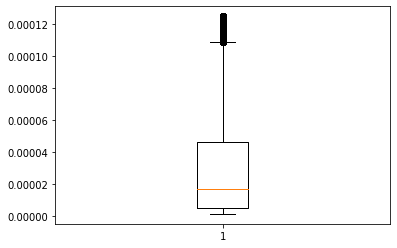

In [306]:
plt.boxplot(winsorize(df_vote['vot_mem_div_rev'],(.1, .1)));

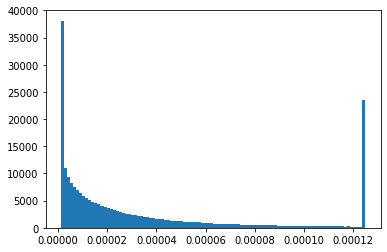

In [308]:
plt.hist(winsorize(df_vote['vot_mem_div_rev'],  (.1,.1)), bins=100);
# plt.hist(winsorize(df_con['con_ct_div_emp_ct'], (0,.1)), bins=100);

### Distribution of 501(c) orgs

#### exempt_status.501c_txt

In [8]:
# identify columns
for c in df.columns:
    if '501' in c:
        print(c)       

exempt_status.501c3
exempt_status.501c_any
exempt_status.501c_txt


In [11]:
# find count of 501(c)(3)
# I'm going to need to convert NaNs to False
df['exempt_status.501c3'].value_counts(dropna=False)

True    179831
NaN      57617
Name: exempt_status.501c3, dtype: int64

In [14]:
# what percent of the total do the 501(c)(3)s make up?

df['exempt_status.501c3'].value_counts(dropna=False)[0] / \
df['exempt_status.501c3'].value_counts(dropna=False).sum()

0.7573489774603281

In [17]:
# what other 501c types are there?
df['exempt_status.501c_txt'].value_counts()

6.0     16719
4.0      8594
5.0      7296
7.0      6795
9.0      3925
8.0      2699
19.0     2688
12.0     2375
14.0     1955
2.0      1644
13.0     1398
10.0      851
25.0      378
15.0       91
17.0       40
29.0       14
26.0        8
11.0        7
16.0        7
27.0        3
18.0        3
23.0        2
20.0        1
Name: exempt_status.501c_txt, dtype: int64

In [ ]:
# for orgs with contractors over 100K
# how are they distributed by org type?



In [23]:
df[~df['contractor_100k_ct'].isnull()].shape


(146216, 110)

In [22]:
# identify columns
for c in df.columns:
    if '100' in c:
        print(c)       

contractor_100k_ct


In [25]:
# how many of the orgs with contractors over 100K are 501c3s
df[~df.name_contractor_1.isnull()].loc[:, 'exempt_status.501c3'].sum()

23103

### Export cleaned data of orgs with contractors for modeling


In [473]:
df_con.to_csv('data/990_model_data.csv', index=None, header=True)

### Identify 501c3 orgs with at least one contractor - export to identify mission category of org.
1. write this to CSV and 
1. use to be able to identify categories of orgs in *990_mission_statement* notebook
1. categories should fall within *Religious, Educational, Charitable, Scientific, Literary, Testing for Public Safety, to Foster National or International Amateur Sports Competition, or Prevention of Cruelty to Children or Animals Organizations*

In [349]:
# identify orgs that have at least one contractor
# over 100K and also are 501c3 in type
# write to a CSV file to be able to 
# identify categories of the 501c3s
df_con[(df_con['exempt_status.501c3'] == True) &
      (~df['name_contractor_1'].isnull())
      ].loc[:,'ein'].to_csv('data/ein_orgs_with_contractors.csv', 
       header=True,
       index=False)

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Count of Vendors for each non-profit

In [41]:
# how many vendors are included?
df[~df.name_contractor_1.isnull()].shape

(30589, 110)

In [42]:
# how many vendors are included?
df[~df.name_contractor_2.isnull()].shape

(19182, 110)

In [43]:
# how many vendors are included?
df[~df.name_contractor_3.isnull()].shape

(14678, 110)

In [44]:
# how many vendors are included?
df[~df.name_contractor_4.isnull()].shape

(11827, 110)

In [45]:
# how many vendors are included?
df[~df.name_contractor_5.isnull()].shape

(9923, 110)

In [14]:
# why are some vendors listed more than once?
df[~df.name_contractor_1.isnull()].loc[:,'name_contractor_1':'name_contractor_2'].head()

,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2
13,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP
17,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING
27,David H Simonds Esq,15 Columbia St Suite 303,Bangor,ME,04401,NaN,Legal Assistance to Members,189920.0,Cloutier Conley & Duffett PA
37,INSIGHT HEALTH CORP,NaN,NaN,NaN,NaN,NaN,MEDICAL STAFFING,455436.0,SODEXO CLINICAL TECHNOLOGY
45,JOHN BOSWELL,5 CLEARVIEW DRIVE,GORHAM,ME,04038,NaN,GOLF PRO,130028.0,NaN


In [61]:
# identical vendors multiple times?
# it appears these contractors are providing different
# types of services to the org

df[(df.name_contractor_1 == df.name_contractor_2) &
  (df.name_contractor_2 == df.name_contractor_3)].head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,doing_business_as,phone,website,address,city,state,country,zip,org_form.corp,org_form.trust,org_form.association,org_form.other_form,org_form.other_form_desc,formation_yr,grp_exempt_num,state_legaldomicile,grp_return,grp_subs_all_incl,exempt_status.501c3,exempt_status.501c_any,exempt_status.501c_txt,gross_receipts,discontinue_dispose25,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string
75739,273428380,CICLAVIA INC,2015-07-01,2016-06-30,2016,NaN,+1 (213) 365-0605,CICLAVIA.ORG,525 S HEWITT STREET,LOS ANGELES,CA,NaN,90013,True,NaN,NaN,NaN,NaN,2010.0,NaN,CA,no,NaN,True,NaN,NaN,1477406,NaN,15,15,8,1185.0,0,0.0,1640977.0,0.0,22415.0,0.0,1663392.0,0.0,0.0,83217.0,87000.0,156216,1535261.0,1705478.0,-42086.0,1276603.0,197316.0,1079287.0,1401912,0,154,12568,1414634,0,0,429403,39000,1469728,1938131,-523497,757390,201600,555790,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,EVENT PRE-PRODUCTION,409250.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,ADMINISTRATIVE SERVICES,62881.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,DEVELOPMENT SERVICES,60893.0,COMMUNITY ARTS RESOURCES,3780 WILSHIRE BOULEVARD SUITE 1020,LOS ANGELES,CA,90010,NaN,EVENT ON-SITE PRODUCTION,56187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,273428380_201606,2015v3.0,201731329349307188,ODY4MjY3ODgwMDc1OTczNzEw
179550,630334002,SOUTHEASTERN IRON WORKERS WELFARE PLAN,2015-02-01,2016-01-31,2016,NaN,+1 (615) 859-0131,NaN,PO BOX 1449,GOODLETTSVILLE,TN,NaN,37370,NaN,True,NaN,NaN,NaN,1953.0,NaN,TN,no,NaN,NaN,True,9.0,37965541,NaN,16,0,0,0.0,0,0.0,0.0,20145528.0,857228.0,0.0,21002756.0,0.0,19937228.0,0.0,0.0,0,1807500.0,21744728.0,-741972.0,15255799.0,78073.0,15177726.0,0,25538091,309120,0,25847211,0,19161438,0,0,1897297,21058735,4788476,19440301,88041,19352260,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,STOP LOSS COVERAGE,895588.0,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,CLAIMS ADMINISTRATION,809444.0,CONNECTICUT GENERAL LIFE INSURANCE COMPA,3500 PIEDMONT ROAD STE 200,ATLANTA,GA,30305,NaN,PPO ACCESS,220540.0,GEMGROUP,1200 THREE GATEWAY CENTER,PITTSBURGH,PA,15222,NaN,PLAN ADMINISTRATION,213483.0,SOUTHERN BENEFIT,2001 CALDWELL DR

#### Join Mission of Non-Profit Orgs - this was running very slowly, by refining the mission statements into fewer categories, I'm hoping to improve this

In [90]:
df.dtypes.head()

ein                int64
name_org          object
tax_date_begin    object
tax_date_end      object
tax_yr             int64
dtype: object

In [93]:
# join EIN numbers and pullin
# the organization’s mission or most significant activities:

df.set_index('ein').join(org_mission.set_index('ein_org'), how='left')


KeyboardInterrupt



In [91]:
# join EIN numbers and pullin
# the organization’s mission or most significant activities:

df.merge(org_mission, 
         how='left',
         left_on='ein',
         right_on='ein_org')

KeyboardInterrupt: 